In [ ]:
# # This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# # TODO: Enter the foldername in your Drive where you have saved the unzipped
# # assignment folder, e.g. 'cs6353/assignments/assignment2/'
# FOLDERNAME = 'assignment2'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# # Now that we've mounted your Drive, this ensures that
# # the Python interpreter of the Colab VM can load
# # python files from within it.
# import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/MyDrive/MS/assignment2/cs6353/datasets
!bash get_datasets.sh
%cd ../..

# Install requirements from colab_requirements.txt
# TODO: Please change your path below to the colab_requirements.txt file
# ! python -m pip install -r /content/drive/My\ Drive/$FOLDERNAME/colab_requirements.txt

Mounted at /content/drive
/content/drive/MyDrive/MS/assignment2/cs6353/datasets
--2024-09-30 04:50:52--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  52.8MB/s    in 3.2s    

2024-09-30 04:50:56 (50.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/MyDrive/MS/assignment2


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://utah.instructure.com/courses/919972/assignments/12590082) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:

from __future__ import print_function
import random
import numpy as np
from cs6353.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
from cs6353.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(cifar10_dir='cs6353/datasets/cifar-10-batches-py', num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

################################################################################
# TODO: Change the path of the CIFAR-10 data directory correctly to            #
# the correct location                                                         #
# Default path is set to cs6353/datasets/cifar-10-batches-py'                 #
################################################################################
cifar10_dir='cs6353/datasets/cifar-10-batches-py'
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data(cifar10_dir)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
from cs6353.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
# Use the validation set to tune the learning rate and regularization strength

from cs6353.classifiers.linear_classifier import LinearSVM

# learning_rates = [1e-7, 1e-8, 1e-9]
# regularization_strengths = [5e6, 5e7, 5e8]

learning_rates = np.linspace(1e-8, 1e-9, num=50)
regularization_strengths = np.linspace(4.5e7, 5e7, num=50)

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifier in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
lr_reg = []
for l_r in learning_rates:
    for reg in regularization_strengths:
        lr_reg.append((l_r, reg))
best_lr = None

for l_r in lr_reg:
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, learning_rate=l_r[0], reg=l_r[1], num_iters=500, batch_size=200, verbose=False)
    y_pred_train = svm.predict(X_train_feats)
    y_pred_val = svm.predict(X_val_feats)
    train_accuracy = np.mean(y_pred_train == y_train)
    val_accuracy = np.mean(y_pred_val == y_val)
    if val_accuracy > best_val:
        best_val = val_accuracy
        best_svm = svm
        best_lr = l_r
    results[l_r] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)
print('best learning rate and regularization strength', best_lr)

lr 1.000000e-09 reg 4.500000e+07 train accuracy: 0.407490 val accuracy: 0.397000
lr 1.000000e-09 reg 4.510204e+07 train accuracy: 0.406469 val accuracy: 0.398000
lr 1.000000e-09 reg 4.520408e+07 train accuracy: 0.401633 val accuracy: 0.396000
lr 1.000000e-09 reg 4.530612e+07 train accuracy: 0.402041 val accuracy: 0.386000
lr 1.000000e-09 reg 4.540816e+07 train accuracy: 0.408551 val accuracy: 0.412000
lr 1.000000e-09 reg 4.551020e+07 train accuracy: 0.400612 val accuracy: 0.384000
lr 1.000000e-09 reg 4.561224e+07 train accuracy: 0.407694 val accuracy: 0.417000
lr 1.000000e-09 reg 4.571429e+07 train accuracy: 0.396265 val accuracy: 0.386000
lr 1.000000e-09 reg 4.581633e+07 train accuracy: 0.399816 val accuracy: 0.395000
lr 1.000000e-09 reg 4.591837e+07 train accuracy: 0.407571 val accuracy: 0.396000
lr 1.000000e-09 reg 4.602041e+07 train accuracy: 0.408735 val accuracy: 0.408000
lr 1.000000e-09 reg 4.612245e+07 train accuracy: 0.411939 val accuracy: 0.409000
lr 1.000000e-09 reg 4.622449

best validation accuracy achieved during cross-validation: 0.313000
best learning rate and regularization strength (1e-07, 5000000.0)

best validation accuracy achieved during cross-validation: 0.342000
best learning rate and regularization strength (1e-08, 50000000.0)

best validation accuracy achieved during cross-validation: 0.335000
best learning rate and regularization strength (1e-08, 50000000.0)

best validation accuracy achieved during cross-validation: 0.361000
best learning rate and regularization strength (1e-09, 489897959.1836735)

best validation accuracy achieved during cross-validation: 0.362000
best learning rate and regularization strength (9.63265306122449e-09, 49591836.73469388)



In [ ]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.418


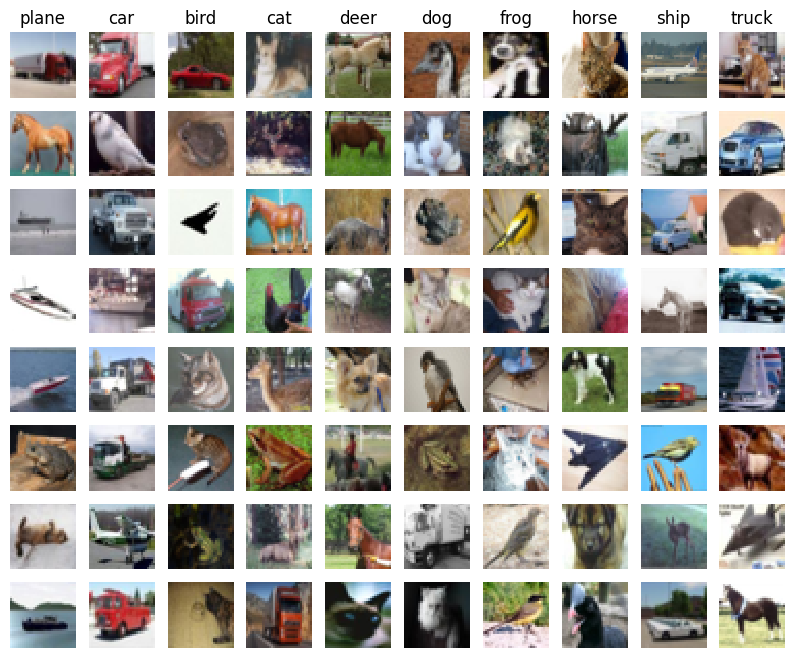

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

some make sense, some do not. For example, some horses and dogs are misclassified as cats. Perhaps, because they are both four-legged animals. But there are also some that does not make sense, namely some cats are misclassified as truck.

In [ ]:
"""From this results, HOG is useful for capturing edges but lacks certain invariances, such as translation. Tuning HOG’s parameters through cross-validation can improve performance. Color histograms help in some cases but are less effective overall. Therefore, we can deduce that HOG and color histograms alone are insufficient to fully discriminate between all classes."""

## Neural Network on image features
Earlier in this assignment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 154)
(49000, 153)


In [ ]:
from cs6353.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
import itertools

learning_rate = [1e-4, 5e-4, 1e-3, 1e-2, 1e-1]
regularization_strength = [0.2, 0.3, 0.4, 0.5, 0.6]

lr_reg = list(itertools.product(learning_rates, regularization_strengths))
best_lr = None

for l_r in lr_reg:

    net = TwoLayerNet(input_dim, hidden_dim, num_classes)

    stats = net.train(X_train_feats, y_train, X_val, y_val,
                num_iters=5, batch_size=200,
                learning_rate=l_r[0], learning_rate_decay=0.95,
                reg=l_r[1], verbose=False)

    y_pred_train = net.predict(X_train_feats)
    y_pred_val = net.predict(X_val_feats)

    train_acc = np.mean(y_train == y_pred_train)
    val_acc = np.mean(y_val == y_pred_val)

    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        best_l_r = l_r

    results[l_r]=  (train_acc, val_acc)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

ValueError: shapes (1000,32,32,3) and (153,500) not aligned: 3 (dim 3) != 153 (dim 0)

In [ ]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

In [ ]:
!jupyter nbconvert --to html /content/drive/MyDrive/MS/assignment2/features.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/MS/assignment2/features.ipynb to html
[NbConvertApp] Writing 1193272 bytes to /content/drive/MyDrive/MS/assignment2/features.html
